# DRAGON relationships pre-processing

See [Makefile](Makefile) for how the results were generated

In [342]:
# initial imports
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from oaklib import get_adapter

from typing import List, Dict

import yaml
import glob

In [343]:
def connect(ont: str) -> pd.DataFrame:
    """
    Connect to an ontology via OAK/sqlite
    
    Assumes already in db folder
    :param ont: 
    :return: 
    """
    return get_adapter(f"downloads/{ont}.db")


In [344]:
from linkml_runtime.utils.formatutils import camelcase
from collections import defaultdict
from functools import lru_cache


@lru_cache
def labels2ids(ont: str) -> Dict[str, List[str]]:
    """
    Get a map of labels to ids for an ontology
    
    :param ont: 
    :return: 
    """
    m = defaultdict(list)
    adapter = connect(ont)
    for id, lbl in adapter.labels(list(adapter.entities())):
        if not lbl:
            continue
        lbl = camelcase(lbl)
        m[lbl].append(id)
    return m

cl_map = labels2ids("cl")
len(cl_map)

16012

In [345]:
def revmap(m: Dict[str, List[str]]) -> Dict[str, str]:
    """
    Reverse a one to many map into a one to one map
    
    :param m: 
    :return: 
    """
    r = {}
    for k, v in m.items():
        for x in v:
            r[x] = k
    return r

In [346]:
from copy import copy
from pydantic import BaseModel


class Outcome(BaseModel):
    """
    Model the outcome of the prediction for a particular term
    
    """
    tp: int = 0
    fp: int = 0
    fn: float = 0
    other: List[str] = []
    
    tp_list: List = []
    fp_list: List = []
    fn_list: List = []
    
    new_terms: List[str] = []
    
    def matches(self, other: 'Outcome') -> bool:
        return self.tp == other.tp and self.fp == other.fp and self.fn == other.fn and self.other == other.other

In [373]:
from oaklib.interfaces import OboGraphInterface
from oaklib.datamodels.vocabulary import IS_A
from oaklib.utilities.obograph_utils import graph_to_image, default_stylemap_path

def score_rels(expected_rels, predicted_rels, ont, term_id:str=None, strict=False, base="default", ignore_ungrounded=True) -> Outcome:
    outcome = Outcome()
    labelmap = labels2ids(ont)
    idmap = revmap(labelmap)
    new_terms = set()
    adapter = get_adapter(f"sqlite:obo:{ont}")
    if not isinstance(adapter, OboGraphInterface):
        raise Exception(f"Only OboGraphInterface supported")
    all_preds = set(expected_rels.keys()).union(set(predicted_rels.keys()))
    all_predicted_tgts = set()
    for pred in all_preds:
        if pred.lower() == 'subclassof':
            preds = [IS_A]
        else:
            pred_ids = labelmap.get(pred)
            if not pred_ids:
                pred_ids = [ids[0] for lbl, ids in labelmap.items() if pred.lower() == lbl.lower()]
            if not pred_ids:
                print(f"MISSING: {pred}")
                continue
                preds = [IS_A]
            else:
                preds = [IS_A, *pred_ids]
        preds = list(set(preds))
        def lbl2id(lbl):
            return labelmap.get(lbl, [lbl])
        expected_tgts = {x: lbl2id(x) for x in expected_rels.get(pred, [])}
        predicted_tgts = {x: lbl2id(x) for x in predicted_rels.get(pred, [])}
        for xs in predicted_tgts.values():
            all_predicted_tgts.update(xs)
        new_terms.update({x for x in predicted_tgts.keys() if x not in labelmap})
        #print(f"PRED: {pred} // predicted= {predicted_tgts} // expected= {expected_tgts}")
        
        predicted_accounted_for = set()
        expected_accounted_for = set()
        for expected_tgt in expected_tgts:
            if expected_tgt in predicted_tgts:
                #print(f"TP: {pred} {expected_tgt}")
                outcome.tp += 1
                outcome.tp_list.append((pred, expected_tgt))
                predicted_accounted_for.add(expected_tgt)
                expected_accounted_for.add(expected_tgt)
            else:
                ok = False
                for expected_tgt_id in expected_tgts.get(expected_tgt, []):
                    ancs = adapter.ancestors(expected_tgt_id, preds)
                    ancs_as_lbls = [idmap.get(x,x) for x in ancs]
                    more_general_predictions = [x for x in ancs_as_lbls if x in predicted_tgts]
                    if more_general_predictions:
                        #print(f"n/a PREDICTED_IS_MORE_GENERAL: {pred} {expected_tgt} // more_general_preds: {more_general_predictions}")
                        predicted_accounted_for.update(more_general_predictions)
                        expected_accounted_for.add(expected_tgt)
                        if strict:
                           outcome.fn += 1
                           outcome.fn_list.append((pred, expected_tgt))
                        else:
                            outcome.fn += 0.5
                            outcome.other.append(f"{pred} MoreGeneralThan {more_general_predictions} {expected_tgt}")
                        ok = True
                        break
        for predicted_tgt in predicted_tgts:
            if predicted_tgt in predicted_accounted_for:
                continue
            if ignore_ungrounded and predicted_tgt not in labelmap:
                continue
            if term_id:
                ancs = adapter.ancestors(term_id, preds)
                ancs_as_lbls = [idmap.get(x, x) for x in ancs]
                #print(f"CHECKING {term_id} {pred} {predicted_tgt} // ancs: {ancs_as_lbls}")
                if predicted_tgt in ancs_as_lbls:
                    outcome.tp += 1
                    outcome.tp_list.append((pred, predicted_tgt))
                    continue
            ok = False
            for predicted_tgt_id in predicted_tgts.get(predicted_tgt, []):
                ancs = adapter.ancestors(predicted_tgt_id, preds)
                ancs_as_lbls = [idmap.get(x, x) for x in ancs]
                #print(pred, predicted_tgt_id, ancs_as_lbls)
                more_general_expected = [x for x in ancs_as_lbls if x in expected_tgts]
                if more_general_expected:
                    #print(f"?? PREDICTED_IS_MORE_SPECIFIC: {pred} {expected_tgt} // more_general_expected: {more_general_expected}")
                    expected_accounted_for.update(more_general_expected)
                    if strict:
                        outcome.fp += 1
                        outcome.fp_list.append((pred, predicted_tgt))
                    else:
                        outcome.other.append(f"{pred} MoreSpecificThan {predicted_tgt} {more_general_expected}")
                    ok = True
                    break
            if not ok:
                #print(f"FP: {pred} {predicted_tgt}")
                outcome.fp += 1
                outcome.fp_list.append((pred, predicted_tgt))
        for expected_tgt in expected_tgts:
            if expected_tgt in expected_accounted_for:
                continue
            #print(f"FN: {pred} {expected_tgt}")
            outcome.fn += 1
            outcome.fn_list.append((pred, expected_tgt))
    outcome.new_terms = list(new_terms)
    if term_id:
        seed = [term_id] + list(all_predicted_tgts)
        #print(seed)
        pred_ids = [IS_A]
        for pred_name in all_preds:
            next_pred_ids = labelmap.get(pred_name, [])
            pred_ids.extend(next_pred_ids)
        pred_ids = list(set(pred_ids))
        graph = adapter.ancestor_graph(seed, pred_ids)
        name = f"term-{term_id}"
        dirn = Path("terms") / base
        dirn.mkdir(exist_ok=True)
        imgfile = f"{name}.png"
        graph_to_image(
            graph,
            seeds=seed,
            stylemap=default_stylemap_path(),
            #configure=configure,
            imgfile=str(dirn / imgfile),
            #view=view,
            format="png",
        )
        mdfile = str(dirn / f"{name}.md")
        with open(mdfile, 'w') as outf:
            outf.write(f"## {term_id}: {adapter.label(term_id)} ({base})\n\n")
            outf.write(f"Outcome: tp: {outcome.tp} fp: {outcome.fp} fn: {outcome.fn}\n\n")
            outf.write(f"### True Positives\n")
            for pred, tgt in outcome.tp_list:
                outf.write(f"* {pred} {tgt}\n")
            outf.write(f"### False Positives\n")
            for pred, tgt in outcome.fp_list:
                outf.write(f"* {pred} {tgt}\n")
            outf.write(f"### False Negatives\n")
            for pred, tgt in outcome.fn_list:
                outf.write(f"* {pred} {tgt}\n")
            outf.write(f"### Other\n")
            for x in outcome.other:
                outf.write(f"* {x}\n")
            outf.write(f"### Predicted terms\n")
            for pred, tgts in predicted_rels.items():
                outf.write(f"* {pred}: {tgts}\n")
            outf.write(f"### Expected terms\n")
            for pred, tgts in expected_rels.items():
                outf.write(f"* {pred}: {tgts}\n")
            outf.write(f"### New terms\n")
            for term in new_terms:
                outf.write(f"* {term}\n")
            outf.write(f"### Graph\n")
            outf.write(f"![{term_id}]({imgfile})\n")
    return outcome
                
outcome = score_rels({"subClassOf": ["Cell"], "PartOf": ["Cerebellum"], "DevelopsFrom": ["StemCell"], "OnlyInTaxon": ["HomoSapiens"]}, {"subClassOf": ["Neuron"], "PartOf": ["Brain", "MadeUp"], "MadeUpRel": ["z", "y"], "OnlyInTaxon": ["HomoSapiens"]}, "cl", term_id="CL:0000540")
print(outcome) 
assert outcome.tp == 2
assert outcome.fp == 0
assert outcome.fn == 2.5
assert len(outcome.other) == 1

MISSING: MadeUpRel
tp=2 fp=0 fn=2.5 other=["PartOf MoreGeneralThan ['Brain'] Cerebellum"] tp_list=[('OnlyInTaxon', 'HomoSapiens'), ('subClassOf', 'Neuron')] fp_list=[] fn_list=[('DevelopsFrom', 'StemCell'), ('subClassOf', 'Cell')] new_terms=['MadeUp']


In [374]:
outcome = score_rels({"subClassOf": ["DentalPulpStemCell"]}, {"PartOf": ["DentalPulp"]}, "cl", term_id="CL:4030035")
outcome
assert outcome.tp == 1
assert outcome.fp == 0
assert outcome.fn == 1

In [375]:
assert score_rels({"subClassOf": ["MadeUp"]}, {}, "cl").matches(Outcome(tp=0, fp=0, fn=1))

In [376]:
assert score_rels({}, {}, "cl").matches(Outcome(tp=0, fp=0, fn=0))

In [377]:
assert score_rels({"subClassOf": ["Cell"]}, {}, "cl").matches(Outcome(tp=0, fp=0, fn=1, other=[]))

In [378]:
assert score_rels({}, {"subClassOf": ["Cell"]}, "cl") .matches(Outcome(tp=0, fp=1, fn=0))

In [379]:
assert score_rels({"subClassOf": ["Cell"]}, {"subClassOf": ["Cell"]}, "cl").matches(Outcome(tp=1, fp=0, fn=0))

In [380]:
outcome = score_rels({"subClassOf": ["Cell"]}, {"subClassOf": ["Neuron"]}, "cl")
assert outcome.tp == 0
assert outcome.fp == 0
assert outcome.fn == 0
assert len(outcome.other) == 1

In [381]:
outcome = score_rels({"subClassOf": ["Neuron"]}, {"subClassOf": ["Cell"]}, "cl")
print(outcome)
assert outcome.tp == 0
assert outcome.fp == 0
assert outcome.fn == 0.5
assert len(outcome.other) == 1

tp=0 fp=0 fn=0.5 other=["subClassOf MoreGeneralThan ['Cell'] Neuron"] tp_list=[] fp_list=[] fn_list=[] new_terms=[]


In [382]:
assert score_rels({"subClassOf": ["Neuron"]}, {"subClassOf": ["StemCell"]}, "cl").matches(Outcome(tp=0, fp=1, fn=1))


In [383]:
def parse_relationships(rel_str: str) -> Dict[str, List[str]]:
    if pd.isnull(rel_str):
        return {}
    if not isinstance(rel_str, str):
        print(f"BAD: {rel_str}")
        return {}
    rels = yaml.safe_load(rel_str)
    m = defaultdict(list)
    for rel in rels:
        if "predicate" not in rel or "target" not in rel:
            print(f"BAD REL: {rel} in {rel_str}")
            continue
        if not isinstance(rel["target"], str):
            print(f"BAD REL: {rel} in {rel_str}")
            continue
        m[rel["predicate"]].append(rel["target"])
    return m

In [387]:
def load_relationships_results_tsv(f: str, ont: str, preds: List=None, strict=False, method="no_method"):
    #adapter = get_adapter(f"sqlite:obo:{ont}")
    res = pd.read_csv(f, comment="#", sep="\t")
    rows = []
    for _, row in res.iterrows():
        expected_rels = parse_relationships(row['expected_relationships'])
        predicted_rels = parse_relationships(row['predicted_relationships'])
        term_id = row["masked_original_id"]
        if preds:
            expected_rels = {k: v for k, v in expected_rels.items() if k in preds}
            predicted_rels = {k: v for k, v in predicted_rels.items() if k in preds}
            base = f"{method}-{'+'.join(preds)}"
        else:
            base = method
        #print(f"Scoring: {expected_rels} // {predicted_rels}")
        outcome = score_rels(expected_rels, predicted_rels, ont, term_id=term_id, strict=strict, base=base, ignore_ungrounded=True)
        if outcome.other:
            print(f"Other: {outcome}")
        outcome = outcome.model_dump()
        #outcome["expected_relationships"] = json.dumps(expected_rels)
        #outcome["predicted_relationships"] = json.dumps(predicted_rels)
        outcome = {"ontology": ont, 
                   "preds": ",".join(preds) if preds else "all",
                   **outcome, **row.to_dict()}
        rows.append(outcome)
    return rows

#rows = load_relationships_results_tsv("results/ont_cl-Prelationships-Mid.original_id-BGFalse-TrNone-Te50-Mgpt-4-EMopenai.results.tsv", "cl", strict=False, method="RAG+gpt4")
#df = pd.DataFrame(rows)
#df.to_csv("foo.tsv", sep="\t")
#df

In [388]:
#rows = load_relationships_results_tsv("results/ont_cl-Prelationships-Mid.original_id-BGFalse-TrNone-Te50-Mgpt-4-EMopenai.results.tsv", "cl", preds=["subClassOf"])
#df = pd.DataFrame(rows)
#df

In [389]:
def get_method(obj: dict) -> str:
    """
    gets the method from the yaml object
    """
    if obj.get("generate_background"):
        return "RAG+background"
    additional = obj.get("additional_collections", [])
    if additional:
        assert len(additional) == 1
        x = additional[0]
        if x.startswith("gh_"):
            return "RAG+github"
        elif x.startswith("devdocs"):
            return "RAG+devdocs"
        else:
            assert False
    else:
        return "RAG"

In [390]:
import re

def load_all_results(preds=None):
    files = glob.glob("results/*.results.yaml")
    rows = []
    for f in files:
        print(f)
        obj = yaml.safe_load(open(f))
        if "Prelationships" not in f:
            continue
        # look for string '/ont_{ONT}-Prelationships' using regex
        m = re.search(r"ont_(\w+)-Prelationships", f)
        assert m
        meth = get_method(obj) + "-" + obj["model_name"]
        print(f, meth)
        ont = m.group(1)
        this_rows = load_relationships_results_tsv(f.replace(".yaml", ".tsv"), ont, preds, strict=False, method=meth)
        for row in this_rows:
            row = {**obj, **row}
            row["method"] = meth
            rows.append(row)
        #rows.extend(this_rows)
        
    return pd.DataFrame(rows)


In [391]:
df = load_all_results()

results/ont_oba-Plabel-Mid.original_id-BGFalse-TrNone-Te50-Mgpt-3.5-turbo-EMopenai.results.yaml
results/ont_cl-Pdefinition-Mid.original_id-BGTrue-TrNone-Te50-Mgpt-4-EMopenai.results.yaml
results/ont_go-Plabel-Mid.original_id-BGTrue-TrNone-Te50-Mgpt-4-EMopenai.results.yaml
results/ont_uberon-Plabel-Mid.original_id-BGFalse-TrNone-Te40-Mgpt-4-EMopenai.results.yaml
results/ont_mondo-Plabel-Mid.original_id-BGTrue-TrNone-Te50-Mgpt-3.5-turbo-EMopenai.results.yaml
results/ont_go-Prelationships-Mid.original_id-BGTrue-TrNone-Te50-Mgpt-4-EMopenai.results.yaml
results/ont_go-Prelationships-Mid.original_id-BGTrue-TrNone-Te50-Mgpt-4-EMopenai.results.yaml RAG+background-gpt-4
Other: tp=1 fp=0 fn=0.5 other=["subClassOf MoreGeneralThan ['Detoxification'] DetoxificationOfInorganicCompound"] tp_list=[('HasPrimaryInput', 'AluminiumCation')] fp_list=[] fn_list=[] new_terms=[]
Other: tp=0 fp=0 fn=0.5 other=["subClassOf MoreGeneralThan ['RetrotransposonSilencing'] RetrotransposonSilencingByMRNADestabilizatio

Other: tp=0 fp=1 fn=2.5 other=["subClassOf MoreGeneralThan ['ConnectiveTissueCell'] MyofibroblastCell"] tp_list=[] fp_list=[('DevelopsFrom', 'MigratoryNeuralCrestCell')] fn_list=[('PartOf', 'LungConnectiveTissue'), ('ParticipatesIn', 'LungAlveolusDevelopment')] new_terms=['Myofibroblast']
Other: tp=1 fp=0 fn=0.5 other=["PartOf MoreGeneralThan ['RespiratorySystem'] RespiratoryTractEpithelium"] tp_list=[('subClassOf', 'CiliatedCell')] fp_list=[] fn_list=[] new_terms=[]
MISSING: LacksCalbindinD28KImmunoreactivity
Other: tp=1 fp=0 fn=0.5 other=["subClassOf MoreGeneralThan ['CiliatedCell', 'EpithelialCell'] CiliatedEpithelialCell"] tp_list=[('PartOf', 'EndometriumEpithelium')] fp_list=[] fn_list=[] new_terms=[]
Other: tp=0 fp=0 fn=0.5 other=["subClassOf MoreGeneralThan ['MediumSpinyNeuron'] DirectPathwayMediumSpinyNeuron"] tp_list=[] fp_list=[] fn_list=[] new_terms=['D1A_dopamineReceptor']
Other: tp=0 fp=0 fn=1.0 other=["subClassOf MoreGeneralThan ['SmoothMuscleCell'] TracheobronchialSmooth

In [363]:
df.to_csv("results/relationship-analysis.tsv", sep="\t", index=False)

In [364]:
isa_df = load_all_results(["subClassOf"])
isa_df.to_csv("results/relationship-analysis-isa.tsv", sep="\t")

results/ont_oba-Plabel-Mid.original_id-BGFalse-TrNone-Te50-Mgpt-3.5-turbo-EMopenai.results.yaml
results/ont_cl-Pdefinition-Mid.original_id-BGTrue-TrNone-Te50-Mgpt-4-EMopenai.results.yaml
results/ont_go-Plabel-Mid.original_id-BGTrue-TrNone-Te50-Mgpt-4-EMopenai.results.yaml
results/ont_uberon-Plabel-Mid.original_id-BGFalse-TrNone-Te40-Mgpt-4-EMopenai.results.yaml
results/ont_mondo-Plabel-Mid.original_id-BGTrue-TrNone-Te50-Mgpt-3.5-turbo-EMopenai.results.yaml
results/ont_go-Prelationships-Mid.original_id-BGTrue-TrNone-Te50-Mgpt-4-EMopenai.results.yaml
results/ont_go-Prelationships-Mid.original_id-BGTrue-TrNone-Te50-Mgpt-4-EMopenai.results.yaml RAG+background-gpt-4
Other: tp=0 fp=0 fn=0.5 other=["subClassOf MoreGeneralThan ['Detoxification'] DetoxificationOfInorganicCompound"] tp_list=[] fp_list=[] fn_list=[] new_terms=[]
Other: tp=0 fp=0 fn=0.5 other=["subClassOf MoreGeneralThan ['RetrotransposonSilencing'] RetrotransposonSilencingByMRNADestabilization"] tp_list=[] fp_list=[] fn_list=[] n

## Loading YAML result objects

Each run generates a single yaml object

In [365]:


def load_results(f):
    """Loads main results summaries"""
    obj = yaml.safe_load(open(f))
    ont = obj["source_collection"].replace("ont_", "")
    for k, v in obj["results"].items():
        obj[k] = v
    del obj["results"]
    obj["task"] = " ".join(obj["fields_to_predict"])
    obj["ontology"] = ont
    #additional = obj.get("additional_collections", [])
    #is_github = any(x for x in additional if x.startswith("gh_")) if additional else []
    #obj["method"] = "background" if obj.get("generate_background") else ("github" if is_github else "direct")
    obj["method"] = get_method(obj)
    return obj

from pathlib import Path
def load_granular_results():
    files = glob.glob("results/*.results.tsv")
    dfs = []
    for file in files:
        yaml_path = file.replace(".tsv", ".yaml")
        if not Path(yaml_path).exists():
            continue
        meta = yaml.safe_load(open(yaml_path))
        # print(file)
        res = pd.read_csv(file, comment="#", sep="\t")
        #res['task'] = res.apply(lambda row :  " ".join(row.get("fields_to_predict", [])), axis = 1)
        #res['ontology'] = res.apply(lambda row :  row.get("source_collection", "").replace("ont_", ""), axis = 1)
        res['task'] =  " ".join(meta.get("fields_to_predict"))
        res['ontology'] = meta.get("source_collection", "").replace("ont_", "")
        res["method"] = get_method(meta)
        res["model_name"] = meta["model_name"]
        res["accuracy"] = res["metric_accuracy"]
        dfs.append(res)
    return pd.concat(dfs)

all_df = load_granular_results()
all_df.describe(include='all')

,masked_id,expected_label,feature_definition,feature_aliases,feature_relationships,feature_logical_definition,masked_original_id,predicted_label,metric_precision,metric_recall,...,predicted_definition,id,label,definition,aliases,relationships,logical_definition,original_id,expected_logical_definition,predicted_logical_definition
count,7782,2164,4272,0.0,5618,1790,7782,2154,7782.00000,7782.000000,...,2559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182,474
unique,494,494,436,NaN,426,122,494,1305,NaN,NaN,...,2202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91,308
top,LungMigratoryDendriticCell,lung migratory dendritic cell,A dendritic cell that captures antigens in a l...,NaN,"[{'predicate': 'subClassOf', 'target': 'Functi...","[{'predicate': 'rdfs:subClassOf', 'target': 'F...",CL:4033045,The Thing,NaN,NaN,...,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'predicate': 'rdfs:subClassOf', 'target': 'F...","[{'predicate': 'rdfs:subClassOf', 'target': 'O..."
freq,20,5,12,NaN,120,18,20,8,NaN,NaN,...,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,9
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.23238,0.237787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.39995,0.405865,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50000,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [366]:
import glob

def load_all_results() -> List[dict]:
    """
    load all yaml files
    """
    files = glob.glob("results/*.results.yaml")
    objs = [load_results(f) for f in files]
    return objs

objs = load_all_results()
len(objs)
    

159

In [367]:
df = pd.DataFrame(objs)
df = df.query("model_name != 'llama2'") # incomplete
df.describe(include="all")

,model_name,embedding_model_name,generate_background,task_started,task_finished,executed_on,agent,extractor,method,source_db_path,...,recall,f1_score,accuracy,specificity,true_positives,true_negatives,false_positives,false_negatives,task,ontology
count,159,159,159,159,159,159,159,159,159,159,...,159.000000,159.000000,159.000000,159.0,159.000000,159.0,159.000000,159.000000,159,159
unique,3,1,2,159,159,1,1,1,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,10
top,gpt-3.5-turbo,openai:,False,2023-09-04 13:31:12.160393,2023-09-04 13:32:28.413164,Darwin-21.6.0-Darwin Kernel Version 21.6.0: Mo...,dae,BasicExtractor,RAG,db,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,definition,cl
freq,64,159,115,1,1,159,159,159,105,159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59,20
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.236555,0.229404,0.214694,0.0,15.823899,0.0,43.654088,38.553459,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.198055,0.192455,0.183317,0.0,15.478664,0.0,19.602695,17.011034,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.060000,0.060000,0.060000,0.0,3.000000,0.0,33.000000,29.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.207639,0.189159,0.160000,0.0,13.000000,0.0,42.000000,39.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.380000,0.378095,0.349833,0.0,26.000000,0.0,47.000000,47.000000,NaN,NaN


In [368]:
df.query(f"task=='relationships' and method=='direct' and model_name=='gpt-4'")

,model_name,embedding_model_name,generate_background,task_started,task_finished,executed_on,agent,extractor,method,source_db_path,...,recall,f1_score,accuracy,specificity,true_positives,true_negatives,false_positives,false_negatives,task,ontology


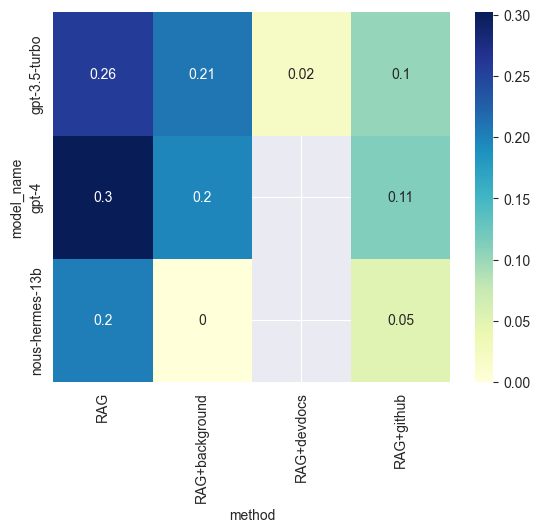

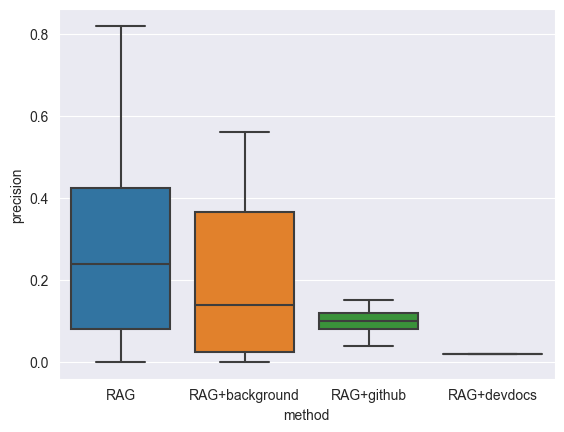

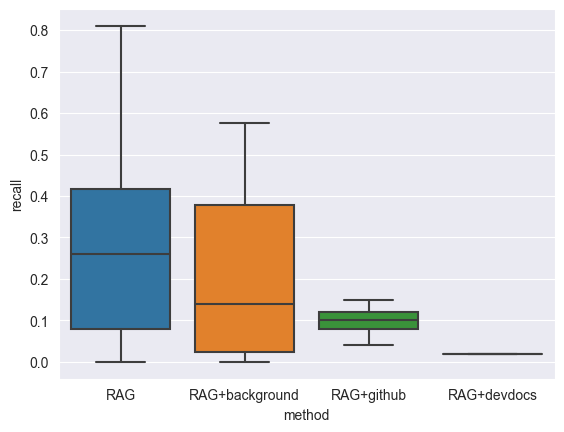

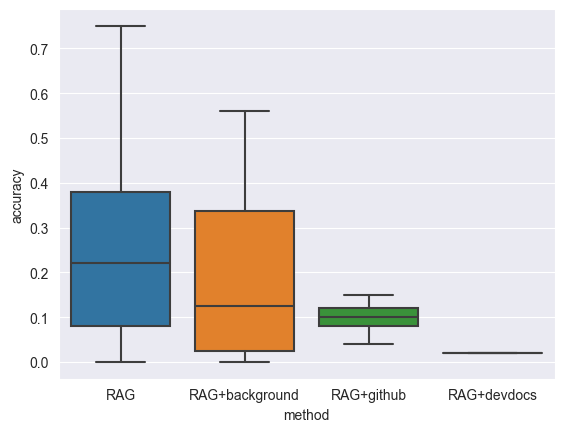

In [369]:

# Line plot for precision across different models and methods
#sns.lineplot(data=df, x='model_name', y='precision', hue='method')
#plt.show()

# Heatmap for precision
heatmap_data = pd.pivot_table(df, values='precision', 
                              index=['model_name'], 
                              columns='method')
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
plt.show()

# Boxplot for precision across different methods
sns.boxplot(data=df, x='method', y='precision')
plt.show()

sns.boxplot(data=df, x='method', y='recall')
plt.show()

sns.boxplot(data=df, x='method', y='accuracy')
plt.show()



In [370]:
from scipy import stats


def hm(task, method, df_x=None, metric="accuracy"):
    if df_x is None:
        df_x = df
    df_x = df_x.query(f"task=='{task}' and method=='{method}'")

    # Heatmap for precision
    heatmap_data = pd.pivot_table(df_x, values=metric, 
                                  index=['model_name'], 
                                  columns='ontology')
    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
    plt.show()

def my_ttest(task, method):
    all_df_x = all_df.query(f"task=='{task}' and method=='{method}'")
    models = all_df_x["model_name"].unique()
    for m1 in models:
        for m2 in models:
            if m2 >= m1:
                continue
            model1_data = all_df_x[(all_df_x['model_name'] == m1)]['accuracy']
            model2_data = all_df_x[(all_df_x['model_name'] == m2)]['accuracy']

            # Step 2: Conduct the T-Test
            # Use ttest_ind to conduct the t-test
            t_statistic, p_value = stats.ttest_ind(model1_data, model2_data)

            print(f'{m1} v {m2}: len {len(model1_data)} v len {len(model2_data)}')
            print(f'{m1} v {m2}: T-statistic: {t_statistic}')
            print(f'{m1} v {m2}: P-value: {p_value}')
    
    

def lp(task, df_x=None):
    if df_x is None:
        df_x = df
    df_x = df_x.query(f"task=='{task}'")

    sns.lineplot(data=df_x, x='model_name', y='accuracy', hue='method')
    plt.show()

## Relationships Task

In [371]:
hm("relationships", "direct")

ValueError: zero-size array to reduction operation fmin which has no identity

In [ ]:
hm("relationships", "direct", metric="precision")

In [ ]:
my_ttest("relationships", "direct")

In [ ]:
lp("relationships")

## Labels Task

In [ ]:
hm("label", "direct")

In [ ]:
my_ttest("label", "direct")

In [ ]:
lp("label")

## Logical Definitions

In [ ]:
import numpy as np

def load_ldef_results_tsv(f):
    res = pd.read_csv(f, comment="#", sep="\t")
    res['expected_logical_definition'].replace('', np.nan, inplace=True)
    res = res[res['expected_logical_definition'].notnull()]
    # Calculate Accuracy per row: (TP + TN) / (TP + TN + FP + FN)
    # Since we can't calculate TN here, we'll omit it from the formula
    res['accuracy'] = res['metric_true_positives'] / (res['metric_true_positives'] + res['metric_false_positives'] + res['metric_false_negatives'])
    res['precision'] = res['metric_true_positives'] / (res['metric_true_positives'] + res['metric_false_positives'])

    return res
    

res = load_ldef_results_tsv("results/ont_go-Plogical_definition-Mid.original_id-BGFalse-TrNone-Te50-Mgpt-4-EMopenai.results.tsv")
res.describe(include="all")

In [ ]:
def load_all_results_ldefs():
    files = glob.glob("results/*.results.yaml")
    objs = []
    for f in files:
        obj = load_results(f)
        if obj["task"] != "logical_definition":
            continue
        accuracy = load_ldef_results_tsv(f.replace(".yaml", ".tsv"))["accuracy"].mean()
        obj["accuracy"] = accuracy
        objs.append(obj)
    return objs

objs = load_all_results_ldefs()

In [ ]:
ldefs_df = pd.DataFrame(objs)

### Logical Definitions (Excluding terms with none)

In [ ]:
hm("logical_definition", "direct", ldefs_df)

### Logical Definitions (including over-prediction)

In [ ]:
hm("logical_definition", "direct")

## Definitions Task

### Definitions (direct)

No additional background knowledge

In [ ]:
hm("definition", "direct")

In [ ]:
my_ttest("definition", "direct")

### Definitions with github as background method

In [ ]:
hm("definition", "github")

### Definitions with auto-generated background summaries

In [ ]:
hm("definition", "background")

In [ ]:
lp("definition")

### Definitions using developer docs

In [ ]:
df.query("ontology == 'cl' and task == 'definition'")["method"].unique()

In [ ]:
hm("definition", "devdocs", df.query("ontology == 'cl'"))

### Significance of different methods

In [ ]:
methods = all_df["method"].unique()
models = all_df["model_name"].unique()
for m1 in methods:
    for m2 in methods:
        if m2 >= m1:
            continue
        for mn in list(models) + [None]:
            if mn is None:
                all_df_x = all_df.query("task == 'definition'")
            else:
                all_df_x = all_df.query(f"task == 'definition' and model_name == '{mn}'")
            m1_data = all_df_x[(all_df_x['method'] == m1)]['accuracy']
            m2_data = all_df_x[(all_df_x['method'] == m2)]['accuracy']

            # Step 2: Conduct the T-Test
            # Use ttest_ind to conduct the t-test
            t_statistic, p_value = stats.ttest_ind(m1_data, m2_data)

            print(f'{mn}:: {m1} v {m2}: T-statistic: {t_statistic}')
            print(f'{mn}:: {m1} v {m2}: P-value: {p_value}')


## Subsumption Analysis

Note that the relationships stats above are calculated on predicting *all* relationships.

To compare with owl2vec, we filter these for only subsumptions (subClassOf) relationships. See https://arxiv.org/pdf/2009.14654.pdf


In [ ]:
import json

def subsumptions(rel_str: str):
    if pd.isnull(rel_str):
        return []
    if not isinstance(rel_str, str):
        print(f"BAD: {rel_str}")
        return []
    rels = yaml.safe_load(rel_str)
    for rel in rels:
         if "predicate" not in rel:
             print(f"BAD REL: {rel} in {rel_str}")
    return [r["target"] for r in rels if r.get("predicate", "") =="subClassOf"]

def calculate_metrics(row):
    expected_set = set(row['expected_subsumptions'])
    predicted_set = set(row['predicted_subsumptions'])
    
    TP = len(expected_set & predicted_set)
    FP = len(predicted_set - expected_set)
    FN = len(expected_set - predicted_set)
    
    # In a classical setting, TN would be calculated here. 
    # However, if you don't have information about what could have been predicted 
    # but wasn't (i.e., the universal set), TN can't be calculated.
    
    return pd.Series({'TP': TP, 'FP': FP, 'FN': FN})
    

def load_subsumption_results_tsv(f):
    res = pd.read_csv(f, comment="#", sep="\t")
    res['expected_subsumptions'] = res.apply(lambda row : subsumptions(row['expected_relationships']), axis = 1)
    res['predicted_subsumptions'] = res.apply(lambda row : subsumptions(row['predicted_relationships']), axis = 1)
    metrics_df = res.apply(calculate_metrics, axis=1)

    # Add the metrics as new columns to the original DataFrame
    df_with_metrics = pd.concat([df, metrics_df], axis=1)

    # Calculate Accuracy per row: (TP + TN) / (TP + TN + FP + FN)
    # Since we can't calculate TN here, we'll omit it from the formula
    df_with_metrics['accuracy'] = df_with_metrics['TP'] / (df_with_metrics['TP'] + df_with_metrics['FP'] + df_with_metrics['FN'])
    df_with_metrics['precision'] = df_with_metrics['TP'] / (df_with_metrics['TP'] + df_with_metrics['FP'])

    return df_with_metrics
    

res = load_subsumption_results_tsv("results/ont_uberon-Prelationships-Mid.original_id-BGFalse-TrNone-Te40-Mgpt-4-EMopenai.results.tsv")
res.describe(include="all")

In [ ]:
import json

def subsumptions(rel_str: str):
    if pd.isnull(rel_str):
        return []
    if not isinstance(rel_str, str):
        print(f"BAD: {rel_str}")
        return []
    rels = yaml.safe_load(rel_str)
    for rel in rels:
         if "predicate" not in rel:
             print(f"BAD REL: {rel} in {rel_str}")
    return [r["target"] for r in rels if r.get("predicate", "") =="subClassOf"]

def calculate_metrics(row):
    expected_set = set(row['expected_subsumptions'])
    predicted_set = set(row['predicted_subsumptions'])
    
    TP = len(expected_set & predicted_set)
    FP = len(predicted_set - expected_set)
    FN = len(expected_set - predicted_set)
    
    # In a classical setting, TN would be calculated here. 
    # However, if you don't have information about what could have been predicted 
    # but wasn't (i.e., the universal set), TN can't be calculated.
    
    return pd.Series({'TP': TP, 'FP': FP, 'FN': FN})
    

def load_subsumption_results_tsv(f):
    res = pd.read_csv(f, comment="#", sep="\t")
    res['expected_subsumptions'] = res.apply(lambda row : subsumptions(row['expected_relationships']), axis = 1)
    res['predicted_subsumptions'] = res.apply(lambda row : subsumptions(row['predicted_relationships']), axis = 1)
    metrics_df = res.apply(calculate_metrics, axis=1)

    # Add the metrics as new columns to the original DataFrame
    df_with_metrics = pd.concat([df, metrics_df], axis=1)

    # Calculate Accuracy per row: (TP + TN) / (TP + TN + FP + FN)
    # Since we can't calculate TN here, we'll omit it from the formula
    df_with_metrics['accuracy'] = df_with_metrics['TP'] / (df_with_metrics['TP'] + df_with_metrics['FP'] + df_with_metrics['FN'])
    df_with_metrics['precision'] = df_with_metrics['TP'] / (df_with_metrics['TP'] + df_with_metrics['FP'])

    return df_with_metrics
    

#res = load_subsumption_results_tsv("results/ont_uberon-Prelationships-Mid.original_id-BGFalse-TrNone-Te40-Mgpt-4-EMopenai.results.tsv")
#res.describe(include="all")

In [ ]:
res["accuracy"].mean()

In [ ]:
def load_all_results_subsumptions():
    files = glob.glob("results/*.results.yaml")
    objs = []
    for f in files:
        obj = load_results(f)
        if obj["task"] != "relationships":
            continue
        accuracy = load_subsumption_results_tsv(f.replace(".yaml", ".tsv"))["accuracy"].mean()
        obj["accuracy"] = accuracy
        objs.append(obj)
    return objs

objs = load_all_results_subsumptions()

### Main subsumption results

In [ ]:
subs_df = pd.DataFrame(objs)

In [ ]:
hm("relationships", "direct", subs_df)

In [ ]:
hm("relationships", "direct", subs_df, metric="precision")

### Subsumptions using background

In [ ]:
hm("relationships", "background", subs_df)

### Subsumptions using github

In [ ]:
#hm("relationships", "github", subs_df)

## Preparing definitions for evaluation

In [ ]:
defs_df = all_df.query("task == 'definition'")
defs_df.groupby('ontology').size().reset_index(name='count')

In [ ]:
len(defs_df)

In [ ]:
len(defs_df["expected_definition"].unique())

In [ ]:

df_defs_gpt_direct = pd.read_csv("results/cl-defs-direct.tsv", sep="\t")
gpt_direct = { row["id"]: row["definition"] for _, row in df_defs_gpt_direct.iterrows() }
objs = []
for _, row in defs_df.iterrows():
    id = row["masked_original_id"]
    if id not in gpt_direct:
        continue
    row = {**row}
    row["predicted_definition"] = gpt_direct[id]
    row["model_name"] = "gpt-4"
    row["method"] = "no_RAG"
    del gpt_direct[id]
    objs.append(row)
all_defs_df = pd.concat([defs_df, pd.DataFrame(objs)])
all_defs_df